In [0]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Useful constants

In [0]:
# Andersen et al. (1979)
Vb = 2.63*10**4
Vt = 5.18*10**4
Ke = 1.58*10**(-4)
K12 = 2.19*10**(-4)
K21 = 1.11*10**(-4)
K = 5.61*10**(-4)
Dz=Dy=Dx = 7*10**(-8)

Lc = 50*10**(-3)
Ld = 250*10**(-3)
Lu = 300*10**(-3)
T_run = 8*3600
T_input = 4*3600

W = Lu + Ld
Depth = 0.02
h_eff = 0.008

dx = Depth/20
dy = W/55
dz = W/55
# dt = 0.25*(2*(Dx/dx**2 + Dy/dy**2))**(-1)
dt = 0.1

x = np.arange(0, Depth+dx, dx)
y = np.arange(-Ld, Lu+dy, dy)
z = np.arange(-Ld, Lu+dz, dz)

Nx = len(x)
Ny = len(y)
Nz = len(z)
Nt = T_run // dt

In [0]:
r = .2
w = (1-r)/r
c = np.zeros((Nx, Ny, Nz))
cb = np.zeros((Nx, Ny, Nz))
dCx0 = 0
dCy = 0

### Initial conditions

### Plot function:

In [0]:
def plot_concentration(c):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    Xax, Yax, Zax = np.meshgrid(x,y,z)
    surf = ax.contour(Zax, Yax, Xax, c, rstride=1, cstride=1,
                           cmap=cm.viridis, linewidth=0, antialiased=False)
    plt.colorbar(surf)
#     ax.set_xlim(0,1)
#     ax.set_ylim(-Ld, Lu)
#     #ax.set_zlim(0, 1.2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('concentration')
    plt.show()

In [0]:
def plot_concentration_contour(c, title):
    fig = plt.figure()
#     ax = fig.gca(projection='3d')
    Xax, Yax = np.meshgrid(x,y)
    min_val = np.min(c)
    max_val = np.max(c)
    contour = plt.contourf(Xax, Yax, c.T, cmap=cm.viridis, levels=np.linspace(min_val, max_val, 51))
    plt.colorbar(contour)
#     plt.xlim(0,1)
#     plt.ylim(-Ld, Lu)
#     ax.set_zlim(0, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    if title:
        plt.title('After '+str(title)+' sec')
#     ax.set_zlabel('concentration')
#     plt.savefig('microneedle/'+title+'.png')
    plt.show()

### Main text

In [0]:
N_coated_y = len(list(filter(lambda x: 0 <= x <= Lc, y)))
N_coated_z = len(list(filter(lambda x: 0 <= x <= Lc, z)))
c_init = 43.#/N_coated/N_coated_z

In [0]:
%matplotlib inline
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            if (0 <= y[j] <= Lc) and (0 <= z[k] <= Lc) and i == int(h_eff/dx):
                c[i,j,k] = c_init
            else:
                c[i,j,k] = 0

cb = np.zeros((Nx, Ny, Nz))
# plot_concentration_contour(c, '')

In [0]:
sum_concentration = []
cu_x = dt/dx**2 * Dx
cu_y = dt/dy**2 * Dy
cu_z = dt/dz**2 * Dz
for t_idx in np.arange(Nt):
    c_temp = c.copy()
    cb_temp = cb.copy()
    if t_idx*dt % 3600 == 0:
        sum_concentration.append(np.sum(cb))
#         plot_concentration_contour(c, str(t_idx*dt))
        
#     Boundary conditions
    c[0,:] = 1/3*(4*c[1,:,:] - c[2,:,:])
    c[Nx-1,:,:] = 0#1/3*(4*c[Nx-2,:] - c[Nx-1,:])#/(3+2*w*dx)
        
    # Along y = Lu and y = -Ld
    c[:,Ny-1,:] = 1/3*(4*c[:,Ny-2,:] - c[:,Ny-3,:])
    c[:,0,:] = 1/3*(4*c[:,1,:] - c[:,2,:])
    
    # Along z = Lu and z = -Ld
    c[:, :, Nz-1] = 1/3*(4*c[:, :, Nz-2] - c[:, :, Nz-3])
    c[:, :, 0] = 1/3*(4*c[:, :, 1] - c[:, :, 2])
    
    

#    Implicit FD method
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            for k in range(1,Nz-1):
                # Along y needle edge
                if (i < int(h_eff/dx) and 0<=(y[j] - Lc)<1e-5 and 0<=z[k]<=Lc+1e-5):
                    c[i,j,k] = 1/3*(4*c[i,j+1,k] - c[i, j+2,k])
                if (i < int(h_eff/dx) and 0<=(-y[j])<1e-5 and 0<=z[k]<=Lc+1e-5):
                    c[i,j,k] = 1/3*(4*c[i,j-1,k] - c[i,j-2,k])
                # Along z needle edge
                if (i < int(h_eff/dx) and 0<=(z[k] - Lc)<1e-5 and 0<=y[j]<=Lc+1e-5):
                    c[i,j,k] = 1/3*(4*c[i,j,k+1] - c[i, j,k+2])
                if (i < int(h_eff/dx) and 0<=(-z[k])<1e-5 and 1e-5<=y[j]<=Lc+1e-5):
                    c[i,j,k] = 1/3*(4*c[i,j,k-1] - c[i,j,k-2])
                if not (i < int(h_eff/dx) and 0 <= y[j] <= Lc):
                    c[i,j,k] = c_temp[i,j,k] \
                               + cu_x*(c_temp[i+1,j,k] - 2*c_temp[i,j,k] + c_temp[i-1,j,k]) \
                               + cu_y*(c_temp[i,j-1,k] + c_temp[i,j+1,k] - 2*c_temp[i,j,k]) \
                               + cu_z*(c_temp[i,j,k-1] + c_temp[i,j,k+1] - 2*c_temp[i,j,k]) \
                               - K*c[i,j,k]*dt \
                               + dt*(K12*cb_temp[i,j,k]*Vb/Vt - K21*c_temp[i,j,k])
                    cb[i,j,k] = cb_temp[i,j,k] + dt*(-(Ke + K12)*cb_temp[i,j,k] + K21*c[i,j,k]*Vt/Vb)
     
    if t_idx*dt <= T_input:
        c[int(h_eff/dx),np.logical_and(y>=0, y<=Lc),np.logical_and(z>=0, z<=Lc)] = c_init
    

## Динамика концентрации в крови

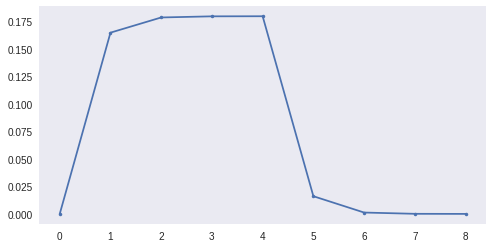

In [17]:
sum_concentration.append(np.sum(cb))
plt.figure(figsize=(8,4))
plt.plot(np.array(sum_concentration)/1000/((Ld+Lu)*Depth), '.-')
plt.grid()

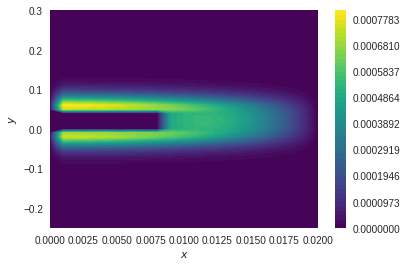

In [63]:
c1 = c.copy()
cb1 = cb.copy()
%matplotlib inline
plot_concentration_contour(cb, '')

## Попробуем без метаболизма

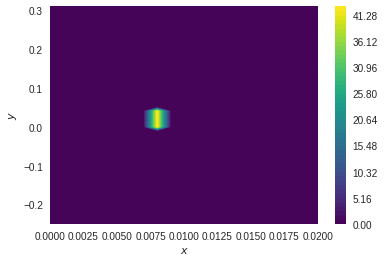

In [8]:
%matplotlib inline
for i in range(Nx):
    for j in range(Ny):
        if (0 <= y[j] <= Lc) and i == int(h_eff/dx):
            c[i,j] = c_init
        else:
            c[i,j] = 0

cb = np.zeros((Nx, Ny))
plot_concentration_contour(c, '')
K = 0
Dy = Dx

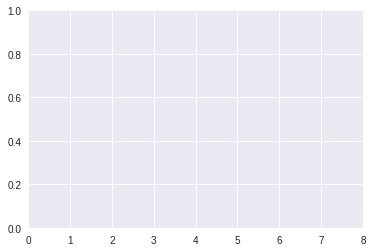

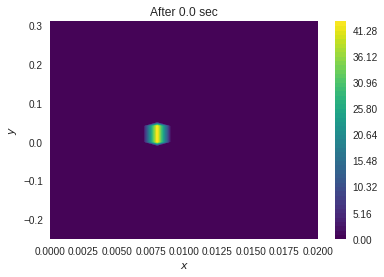

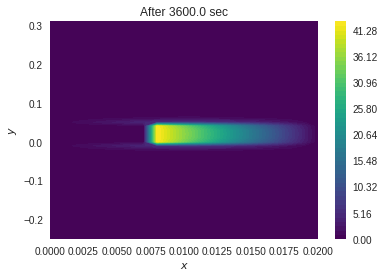

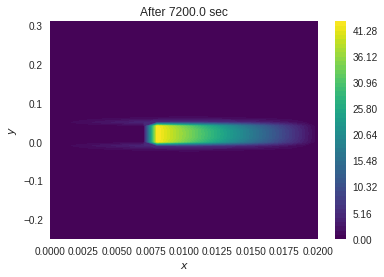

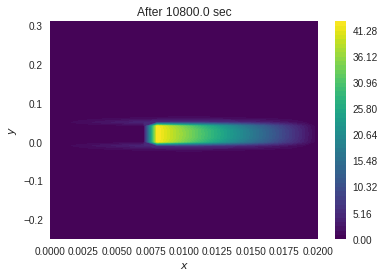

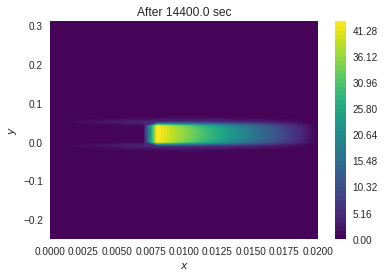

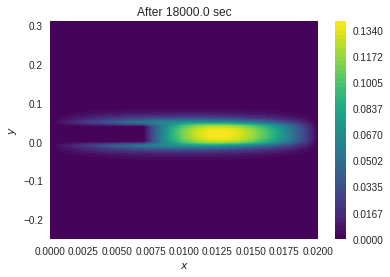

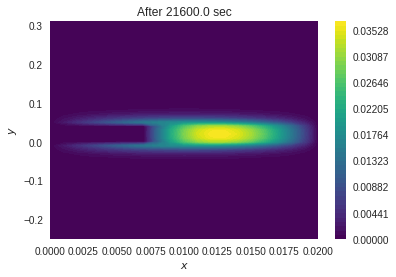

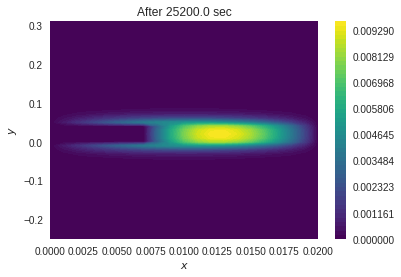

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(0,8)
plt.show()
sum_concentration = []
cu_x = dt/dx**2 * Dx
cu_y = dt/dy**2 * Dy
for t_idx in np.arange(Nt):
    c_temp = c.copy()
    cb_temp = cb.copy()
    if t_idx*dt % 3600 == 0:
        sum_concentration.append(np.sum(cb))
        plot_concentration_contour(c, str(t_idx*dt))
        if t_idx > 0:
            ax.plot(sum_concentration, '.-')
        
#     Boundary conditions
    c[0, :] = 1/3*(4*c[1,:] - c[2,:])
    c[Nx-1,:] = 0#1/3*(4*c[Nx-2,:] - c[Nx-1,:])#/(3+2*w*dx)
        
    # Along y = Lu and y = -Ld
    c[:, Ny-1] = 1/3*(4*c[:, Ny-2] - c[:, Ny-3])
    c[:, 0] = 1/3*(4*c[:, 1] - c[:, 2])
    
#     # Along z = Lu and z = -Ld
#     c[:, :, Nz-1] = 1/3*(4*c[:, :, Nz-2] - c[:, :, Nz-3])
#     c[:, :, 0] = 1/3*(4*c[:, :, 1] - c[:, :, 2])
    
    

#    Implicit FD method
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
                if (i < int(h_eff/dx) and 0<=(y[j] - Lc)<1e-5):
                    c[i, j] = 1/3*(4*c[i, j+1] - c[i, j+2])
                if (i < int(h_eff/dx) and 0<=(-y[j])<1e-5):
                    c[i, j] = 1/3*(4*c[i, j-1] - c[i, j-2])
                if not (i < int(h_eff/dx) and 0 <= y[j] <= Lc):
                    c[i,j] = c_temp[i,j] + cu_x*(c_temp[i+1,j] - 2*c_temp[i,j] + c_temp[i-1,j]) \
                                     + cu_y*(c_temp[i,j-1] + c_temp[i,j+1] - 2*c_temp[i,j]) \
                                     + dt*(K12*cb_temp[i,j]*Vb/Vt - K21*c_temp[i,j])
                    cb[i,j] = cb_temp[i,j] + dt*(-(Ke + K12)*cb_temp[i,j] + K21*c[i,j]*Vt/Vb)
     
    if t_idx*dt <= T_input:
        c[int(h_eff/dx), np.logical_and(y>=0, y<=Lc)] = c_init
    

In [1]:
sum_concentration.append(np.sum(cb)/(Nx*Ny))
plt.figure(figsize=(8,4))
plt.plot(np.array(sum_concentration)/1000, '.-')
plt.grid()

NameError: ignored

In [0]:
c4 = c.copy()
cb4 = cb.copy()

In [0]:
np.sum(cb)

418.0973338768862

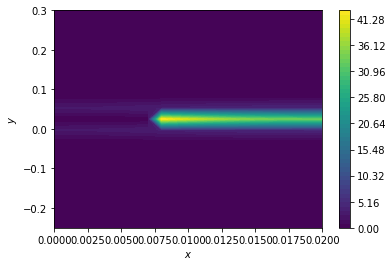

In [0]:
plot_concentration_contour(c4, "")

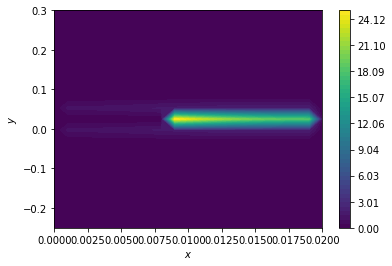

In [0]:
plot_concentration_contour(cb4, "")

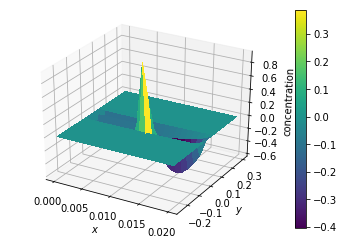

In [0]:
plot_concentration(cb1-cb2)

# Одномерный случай (Dy = 0)

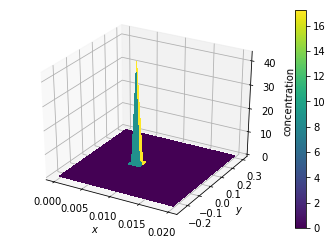

In [0]:
%matplotlib inline
for i in range(Nx):
    for j in range(Ny):
        if (0 <= y[j] <= Lc) and i == int(h_eff/dx):
            c[i,j] = 43.
        else:
            c[i,j] = 0

cb = np.zeros((Nx, Ny))
plot_concentration(c)
K = 5.61*10**(-4)
Dy = 0

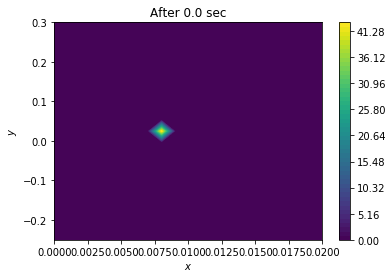

In [0]:
cu_x = dt/dx**2 * Dx
cu_y = dt/dy**2 * Dy
for t_idx in np.arange(Nt//4):
    c_temp = c.copy()
    cb_temp = cb.copy()
    if t_idx*dt % 3600 == 0:
        plot_concentration_contour(c, str(t_idx*dt))
        
#     Boundary conditions
    c[0, :] = 1/3*(4*c[1,:] - c[2,:]) - K*c[0, :]
    c[Nx-1,:] = 1/3*(4*c[Nx-2,:] - c[Nx-1,:])/(3+2*w*dx)
        
    # Along y = Lu and y = -Ld
    c[:, Ny-1] = 1/3*(4*c[:, Ny-2] - c[:, Ny-3])
    c[:, 0] = 1/3*(4*c[:, 1] - c[:, 2])

#    Implicit FD method
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            if not (i <= int(h_eff/dx) and 0 <= y[j] <= Lc):
                c[i,j] = c_temp[i,j] + cu_x*(c_temp[i+1,j] - 2*c_temp[i,j] + c_temp[i-1,j]) \
                                 + cu_y*(c_temp[i,j-1] + c_temp[i,j+1] - 2*c_temp[i,j]) - K*c[i,j]*dt \
                                 + dt*(K12*cb_temp[i,j]*Vb/Vt - K21*c_temp[i,j])
                cb[i,j] = cb_temp[i,j] + dt*(-(Ke + K12)*cb_temp[i,j] + K21*c[i,j]*Vt/Vb)

In [0]:
c3 = c.copy()
cb3 = cb.copy()

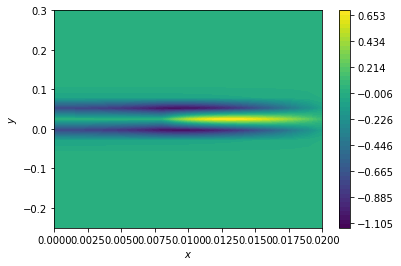

In [0]:
plot_concentration_contour(c3-c1, "")

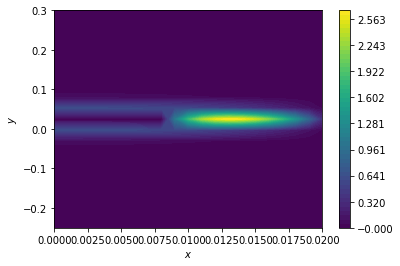

In [0]:
plot_concentration_contour(c2-c1, "")